__We see that even with no noise and a large number of features, the error level doesn't go below ~10%. Let's explore the misclassified examples. It could be entirely due to the way the task is set up.__

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from estimator import RFClassifier, relu
from data_fns import noisy_sin_signal, data_matrix, butter_bandpass_filter
import dask

In [2]:
from dask.distributed import Client
client = Client(threads_per_worker=7, n_workers=10)
client

Client Scheduler: tcp://127.0.0.1:38145 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 10 Cores: 70 Memory: 135.06 GB


In [3]:
def bp_weights(M, N, lowcut, highcut, fs):
    J = np.random.randn(M, N)
    J = butter_bandpass_filter(J, lowcut, highcut, fs)
    return J.T

def l_clf(classifier, params, X_train, y_train, X_test, y_test):
    clf = classifier(**params)
    clf.fit(X_train, y_train)
    return clf.score(X_test, y_test)

In [4]:
## generate data
seed = 12
signal, label = noisy_sin_signal(f_s=2000, dur=10, sig_dur=0.05, f_signal=50, a=1, seed=seed)
delta = 0.09
N = int(2000 * delta)
X, y = data_matrix(signal, label, N)

idx = int(len(X) * 2 / 3)
X_train, y_train = X[:idx], y[:idx]
X_test, y_test = X[idx:], y[idx:]

# classify and transform
f = lambda M, N: bp_weights(M, N, lowcut=10, highcut=80, fs=2000)
clf = RFClassifier(width=400, weights= 'bandpass', weight_fun=f, nonlinearity=relu, seed=seed)
clf.fit(X_train, y_train)
err = 1 - clf.score(X_test, y_test)
y_pred = clf.predict(X_test)
X_test_transform = clf.transform(X_test)

# find index of incorrect samples 
idx = np.where(y_test == y_pred)[0]

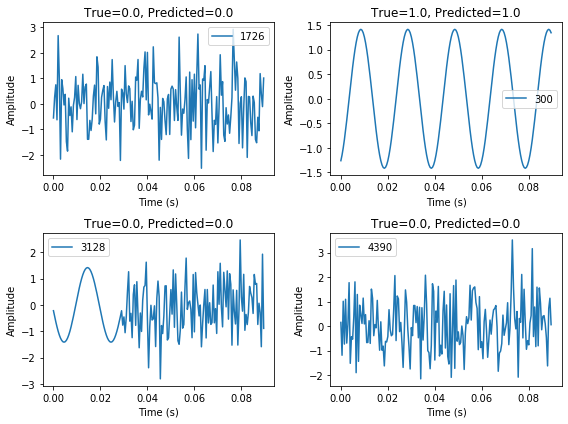

In [7]:
# np.random.seed(33)
t = np.arange(0, delta, 1/2000)
fig = plt.figure(figsize=(8, 6))
# plt.suptitle('Misclassified test examples')
for i in range(4):
    ax = fig.add_subplot(2, 2, i + 1)
    for _ in range(1):
        i = np.random.choice(idx)
        plt.title('True=%0.1f, Predicted=%0.1f' % (y_test[i], y_pred[i]))
        plt.plot(t, X_test[i], label=i)
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
    plt.legend()
plt.tight_layout()

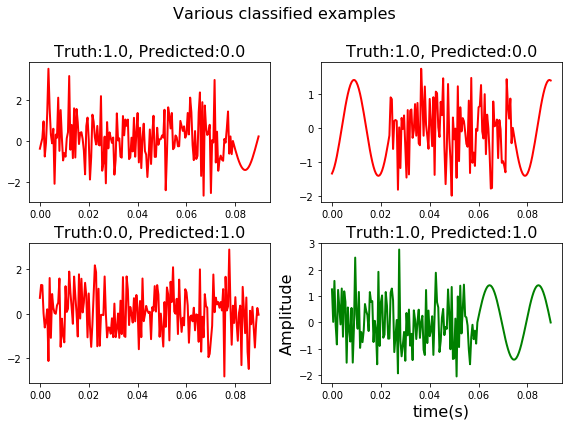

In [12]:
indexes = [4529, 1339, 5047, 3268]
color = ['r', 'r', 'r', 'g']
fig = plt.figure(figsize=(8, 6))
plt.suptitle('Various classified examples', fontsize=16)
for i, ii in enumerate(indexes):
    ax = fig.add_subplot(2, 2, i + 1)
    plt.title('Truth:%0.1f, Predicted:%0.1f' % (y_test[ii], y_pred[ii]), fontsize=16)
    plt.plot(t, X_test[ii], color[i], lw=2)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
plt.xlabel('time(s)', fontsize=16)
plt.ylabel('Amplitude', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.savefig('figures/rand_classification/misclassified/clf_a=1_misclassified.png')